# Image Processor
The goal of this notebook is to create a model that can classify images of the following two classes:
- Kaninchen
- Feldhase

The comments in this notebook are plenty and generated mostly using the help of artificial intelligence. This approach is chosen, as it enables both the developers and the users of this notebook to understand the code better.

# Imports

In [52]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Adjust the GPU memory growth dynamically

In [54]:
gpus = tf.config.experimental.list_physical_devices('GPU') # Get the list of GPUs
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True) # enable tensorflow to allocate memory dynamically -> use only as much GPU memory as needed
gpus

[]

In [55]:
tf.config.list_physical_devices('GPU') # Check if GPU is available

[]

# Load images and transform them into a numpy array

In [79]:
# Create a dataset from the images in the folder (with 400 images per dataset)
data = tf.keras.utils.image_dataset_from_directory('photos', batch_size=400, image_size=(256, 256), shuffle=True)

# Create an iterator to iterate over the batches of the dataset (only one batch in our case)
data_iterator = data.as_numpy_iterator()

# Get the first batch (the only one in our case)
images, labels = data_iterator.next()

# First row of pixels of the first image in RGB to show how the data looks like
print(images[0].astype(int)[0])

Found 400 files belonging to 2 classes.
[[ 82 116  79]
 [ 83 115  80]
 [ 84 115  81]
 [ 87 116  85]
 [ 91 119  89]
 [ 95 121  92]
 [ 98 124  95]
 [ 98 124  95]
 [100 126  97]
 [103 129 100]
 [108 134 105]
 [110 136 108]
 [112 134 113]
 [110 134 112]
 [108 133 111]
 [110 135 113]
 [116 144 121]
 [115 144 120]
 [115 142 111]
 [120 147 116]
 [126 153 122]
 [131 158 127]
 [134 161 130]
 [135 162 131]
 [132 162 128]
 [129 159 125]
 [125 155 121]
 [128 158 124]
 [133 163 129]
 [132 162 128]
 [126 157 115]
 [121 152 109]
 [121 152 109]
 [121 152 109]
 [120 151 108]
 [118 149 106]
 [116 146 112]
 [109 139 107]
 [106 135 105]
 [101 129 104]
 [ 97 125 103]
 [ 93 120  99]
 [ 94 114 103]
 [ 86 104  97]
 [ 80  96  93]
 [ 76  90  90]
 [ 71  83  86]
 [ 71  82  88]
 [ 70  83  91]
 [ 66  79  87]
 [ 67  80  88]
 [ 67  80  88]
 [ 65  78  86]
 [ 64  77  85]
 [ 62  75  83]
 [ 63  76  84]
 [ 62  75  83]
 [ 63  76  84]
 [ 59  72  80]
 [ 57  70  78]
 [ 60  73  81]
 [ 60  73  81]
 [ 60  73  81]
 [ 58  71  79]


# Inspect the shape of the images

In [80]:
num_images = len(images)
num_classes = len(np.unique(labels))
print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")

Number of images: 400
Number of classes: 2


## Scale the images

This can be done here with /255, as the value range of RGB is only between 0 and 255.

In [81]:
images = images / 255.0 # divide by float forces the result to be a float

# Inspect scaled first row of pixels of the first image in RGB
print(images[0][0])

[[0.32255286 0.4558862  0.31078815]
 [0.32647443 0.45390242 0.31470972]
 [0.33041131 0.45197994 0.3186466 ]
 [0.3428194  0.45654488 0.33497626]
 [0.35889247 0.46666667 0.34906557]
 [0.37254903 0.4745098  0.36078432]
 [0.38493413 0.4868949  0.37316942]
 [0.38531327 0.48727405 0.37354857]
 [0.39411765 0.49607843 0.38235295]
 [0.40648744 0.50844824 0.39472273]
 [0.42469746 0.52665824 0.41293275]
 [0.43458182 0.5365426  0.42424172]
 [0.44117647 0.527451   0.4439185 ]
 [0.43333334 0.527451   0.44117647]
 [0.4254902  0.5235294  0.4372549 ]
 [0.4341452  0.5321844  0.44590992]
 [0.45507047 0.5648744  0.4746783 ]
 [0.4525697  0.56555223 0.47228095]
 [0.45238206 0.5577053  0.4372549 ]
 [0.47377834 0.5796607  0.45809206]
 [0.4948759  0.60075825 0.47918963]
 [0.51514244 0.6210248  0.4994562 ]
 [0.5284888  0.63437116 0.51280254]
 [0.5294118  0.63529414 0.5137255 ]
 [0.52104014 0.6386872  0.50535387]
 [0.5074525  0.6250996  0.49176624]
 [0.49255133 0.6101984  0.47686505]
 [0.5053692  0.62301624 0.48

# Split the data into train and test data

In [82]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create the model

In [113]:
# sequential means that the layers are stacked on top of each other leading to a feed forward neural network
model = tf.keras.models.Sequential([
    # Adding a convolutional layer to detect features in the images
    
    # 16 filters to detect 16 different features like edges, textures, structure etc.
    # 3x3 kernel size to detect features in a 3x3 area
    # 1 stride to move the kernel by 1 pixel
    # relu activation function to introduce non-linearity
    # input shape: height, width, colors/channels (RGB)
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)), # output shape: 254x254x16 (width, height, features)

    # Adding a max pooling layer to reduce the dimensionality of the data
    # achieved by taking the maximum value of a 2x2 area as the representative value for that area
    tf.keras.layers.MaxPool2D(), # output shape: 127x127x16
    
    # Adding more layers to continously learn more complex features
    # Continouse learning of more complex features is achieved by increasing the number of filters
    # A more compact representation of the data is achieved by reducing the kernel size continuously via max pooling
    tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'), # output shape: 125x125x32
    tf.keras.layers.MaxPool2D(), # output shape: 62x62x32
    tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'), # output shape: 60x60x64
    tf.keras.layers.MaxPooling2D(), # output shape: 30x30x64 (width, height, features)
    
    # Adding a flatten layer to transform the 2D data into a 1D vector
    tf.keras.layers.Flatten(), # output shape: 57600
    
    # Adding a dense layer to learn the classification
    tf.keras.layers.Dense(256, activation='relu'),
    
    # Adding the output layer to classify the images - either as a Kaninchen or as a Feldhase
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuring the neural network model

In [114]:
# 'compile' configures the selected neural network model
# 'adam' adapts the learning rate of each parameter individually, aiming to minimize the loss function (binary crossentropy in our case)
# the metrics are used to measure the performance of our model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Train the model

In [119]:
# Implementing early stopping to prevent overfitting
# 'patience' is the number of epochs with no improvement after which training will be stopped
# 'restore_best_weights' restores the weights from the epoch with the best value of the monitored quantity
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# 'fit' trains the model
# 'epochs' is the number of times the model is trained on the whole dataset
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100, callbacks=[early_stopping])

Epoch 1/20
4/4 [==============================] - 7s 1s/step - loss: 0.1900 - accuracy: 0.9438 - val_loss: 0.3976 - val_accuracy: 0.8250
Epoch 2/20
4/4 [==============================] - 4s 984ms/step - loss: 0.1682 - accuracy: 0.9594 - val_loss: 0.3896 - val_accuracy: 0.8375
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 0.1257 - accuracy: 0.9719 - val_loss: 0.4372 - val_accuracy: 0.7750
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 0.1088 - accuracy: 0.9750 - val_loss: 0.4268 - val_accuracy: 0.7625
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.0876 - accuracy: 0.9844 - val_loss: 0.4870 - val_accuracy: 0.7500


# Plot the training and the validation accuracy, as well as the loss

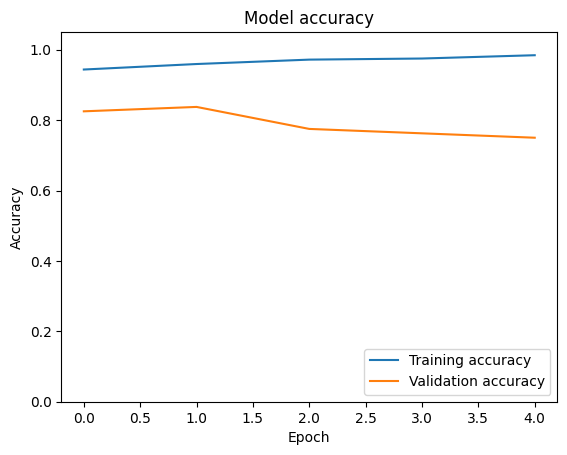

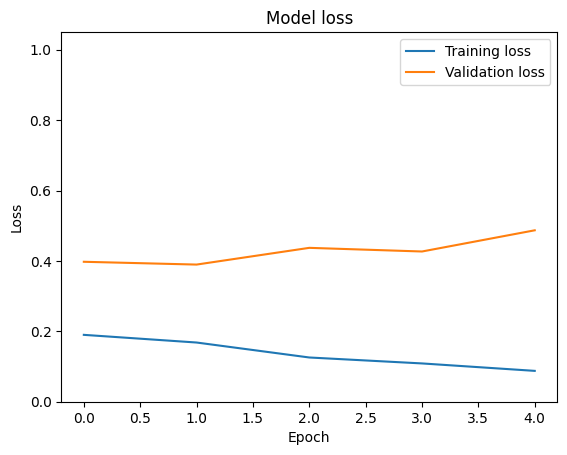

In [120]:
import matplotlib.pyplot as plt

# Plot the training and the validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1.05)  # Set y-axis limits to start at 0 and end at 1.05
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right') # loc='lower right' to place the legend in the lower right corner
plt.show()

# Plot the training and the validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 1.05)
plt.legend(['Training loss', 'Validation loss'], loc='upper right') # loc='upper right' to place the legend in the upper right corner
plt.show()

In [121]:
# Evaluate the model based on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2) # verbose=2 to suppress the progress bar
print(f'Test accuracy: {test_acc}')

3/3 - 0s - loss: 0.3896 - accuracy: 0.8375 - 251ms/epoch - 84ms/step
Test accuracy: 0.8374999761581421
